In [1]:
import tensorflow as tf
import numpy as np
import math


In [2]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [3]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

In [4]:
# Load data
data = np.load('data_with_labels.npz')
train = data['arr_0']/255.
labels = data['arr_1']


In [5]:
# Look at some data
print(train[0])
print(labels[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0


In [6]:
# If you have matplotlib installed
import matplotlib.pyplot as plt
plt.ion()

In [7]:
def to_onehot(labels,nclasses = 5):
    '''
    Convert labels to "one-hot" format.
    >>> a = [0,1,2,3]
    >>> to_onehot(a,5)
    array([[ 1.,  0.,  0.,  0.,  0.],
           [ 0.,  1.,  0.,  0.,  0.],
           [ 0.,  0.,  1.,  0.,  0.],
           [ 0.,  0.,  0.,  1.,  0.]])
    '''
    outlabels = np.zeros((len(labels),nclasses))
    for i,l in enumerate(labels):
        outlabels[i,l] = 1
    return outlabels

onehot = to_onehot(labels)

In [8]:
# Split data into training and validation
indices = np.random.permutation(train.shape[0])
valid_cnt = int(train.shape[0] * 0.1)
test_idx, training_idx = indices[:valid_cnt], indices[valid_cnt:]
test, train = train[test_idx,:], train[training_idx,:]
onehot_test, onehot_train = onehot[test_idx,:], onehot[training_idx,:]


In [9]:
sess = tf.InteractiveSession()

In [10]:
# These will be inputs
## Input pixels, flattened
x = tf.placeholder("float", [None, 1296])
## Known labels
y_ = tf.placeholder("float", [None,5])


In [11]:
# Hidden layer
num_hidden = 128
W1 = tf.Variable(tf.truncated_normal([1296, num_hidden],
                                        stddev=1./math.sqrt(1296)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_hidden]))
h1 = tf.sigmoid(tf.matmul(x,W1) + b1)


In [12]:
# Output Layer
W2 = tf.Variable(tf.truncated_normal([num_hidden, 5],
                                        stddev=1./math.sqrt(5)))
b2 = tf.Variable(tf.constant(0.1,shape=[5]))



In [13]:
# Just initialize
sess.run(tf.global_variables_initializer())

In [14]:
# Define model
y = tf.nn.softmax(tf.matmul(h1,W2) + b2)

In [15]:
### End model specification, begin training code

In [16]:
# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits = y + 1e-50, labels = y_))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [17]:
# How we train
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [18]:
# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [19]:
epochs = 5000
train_acc = np.zeros(epochs//10)
test_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})
        train_acc[i//10] = A

        # And now the validation set
        A = accuracy.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test})
        test_acc[i//10] = A
    train_step.run(feed_dict={x: train.reshape([-1,1296]), y_: onehot_train})

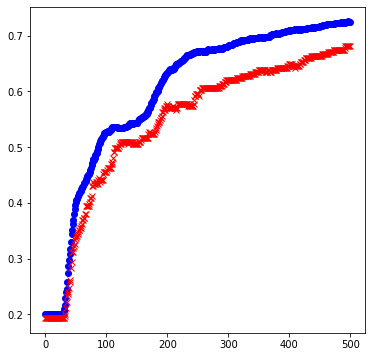

In [20]:
# Plot the accuracy curves
plt.figure(figsize=(6,6))
plt.plot(train_acc,'bo')
plt.plot(test_acc,'rx')

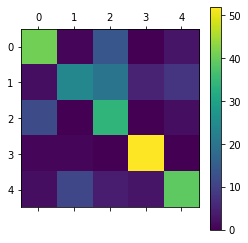

In [21]:
# Look at the final testing confusion matrix
pred = np.argmax(y.eval(feed_dict={x: test.reshape([-1,1296]), y_: onehot_test}), axis = 1)
conf = np.zeros([5,5])
for p,t in zip(pred,np.argmax(onehot_test,axis=1)):
    conf[t,p] += 1

plt.matshow(conf)
plt.colorbar()

<Figure size 432x432 with 0 Axes>

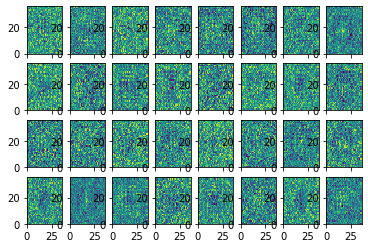

In [22]:
# Let's look at a subplot of some weights
plt.figure(figsize=(6,6))
f, plts = plt.subplots(4,8, sharex=True)
for i in range(32):
    plts[i//8, i%8].pcolormesh(W1.eval()[:,i].reshape([36,36]))

fin. 